In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
borhanitrash_twitter_financial_news_sentiment_dataset_path = kagglehub.dataset_download('borhanitrash/twitter-financial-news-sentiment-dataset')

print('Data source import complete.')


100%|██████████| 438k/438k [00:00<00:00, 57.9MB/s]

Extracting files...
Data source import complete.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!nvidia-smi

Wed Oct 29 17:00:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, BertTokenizer, BertForSequenceClassification

In [7]:
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
train_data = pd.read_csv(f"{borhanitrash_twitter_financial_news_sentiment_dataset_path}/sent_train.csv")
valid_data = pd.read_csv(f"{borhanitrash_twitter_financial_news_sentiment_dataset_path}/sent_valid.csv")

In [9]:
train_data.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [10]:
train_data.text[100]

"O'Reilly Automotive stock price target cut to $405 from $415 at J.P. Morgan"

In [11]:
train_data.shape, valid_data.shape

((9543, 2), (2388, 2))

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [13]:
train_data.label.value_counts()

,count
label,
2,6178
1,1923
0,1442


In [14]:
print("all columns: ", train_data.columns)

all columns:  Index(['text', 'label'], dtype='object')


In [15]:
import string
stop_words = set(stopwords.words('english'))
punctuations = string.punctuation

# Define a text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', punctuations))

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Tokenize
    nltk.download('punkt_tab', quiet=True) # Add this line
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Rejoin tokens
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply the cleaning function to the DataFrame
train_data['text'] = train_data['text'].apply(clean_text)
valid_data['text'] = valid_data['text'].apply(clean_text)

In [16]:
train_data.text[100]

'oreilly automotive stock price target cut jp morgan'

In [17]:
# count of ratings
fig = px.histogram(train_data,
             x = 'label',
             title = 'Histogram of Review Label',
             template = 'ggplot2',
             color = 'label',
             color_discrete_sequence= px.colors.sequential.Blues_r,
             opacity = 0.8,
             height = 525,
             width = 835,
            )

fig.update_yaxes(title='Count')
fig.show()

In [18]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40,
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

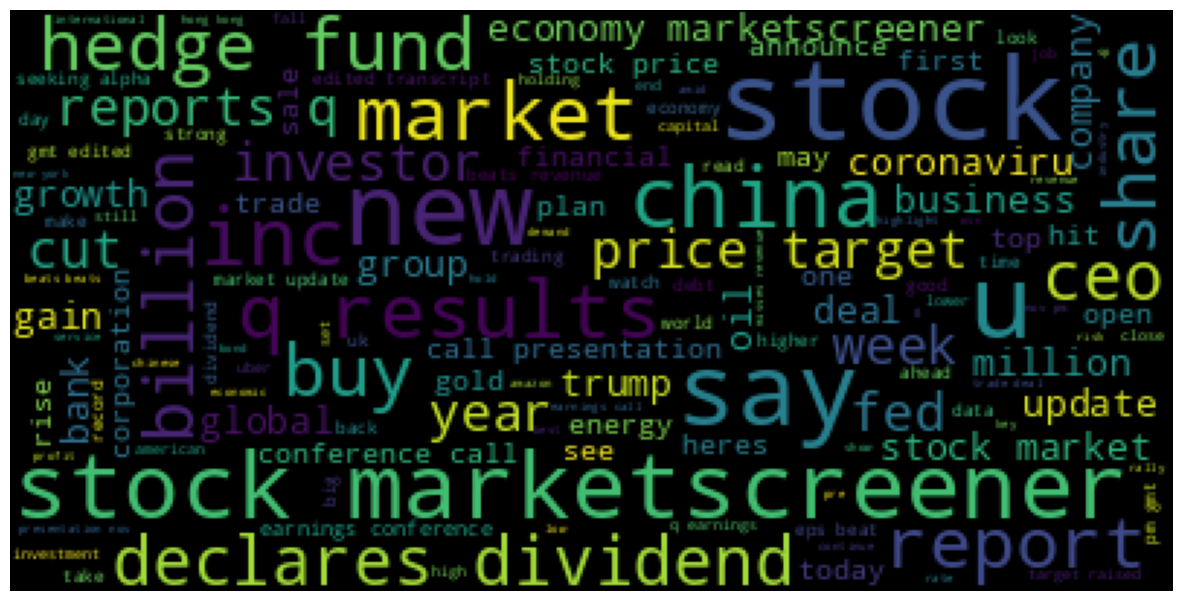

In [19]:
show_wordcloud(train_data["text"].values)

In [20]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange
fig.add_trace(go.Pie(labels=train_data.label.value_counts().index,
                             values=train_data.label.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=train_data.label.value_counts().index, y=train_data.label.value_counts().values, marker_color = colors), 1,2)

fig.show()

In [21]:
texts = train_data['text']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

In [25]:
title_ = ["negative", "neutral", "positive"]
fig = make_subplots(rows=1, cols=3, subplot_titles=title_) # Add subplot_titles here


for i in range(3):
    texts = train_data[train_data["label"] == i]['text']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

In [26]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

In [27]:
# unigram
fig = make_subplots(rows=1, cols=3)

title_ = ["negative", "neutral", "positive"]


for i in range(3):
    texts = train_data[train_data["label"] == i]['text']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)


fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common unigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))
fig.show()

In [28]:
#trigram

fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = train_data[train_data["label"] == i]['text']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    top_n_bigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1),

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common trigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))

fig.show()

In [29]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [30]:
train_encodings = tokenizer(train_data['text'].tolist(), truncation=True, padding=True, max_length=512)
valid_encodings = tokenizer(valid_data['text'].tolist(), truncation=True, padding=True, max_length=512)

In [31]:
train_encodings[0]

Encoding(num_tokens=65, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [32]:
train_labels = train_data['label'].tolist()
valid_labels = valid_data['label'].tolist()

In [33]:
train_labels[0]

0

In [34]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,}")

count_parameters(model)


Total parameters: 109,484,547
Trainable parameters: 109,484,547


In [35]:
for name, param in model.named_parameters():
    print(f"{name:60} | {'Trainable' if param.requires_grad else 'Frozen'} | Shape: {param.shape}")


bert.embeddings.word_embeddings.weight                       | Trainable | Shape: torch.Size([30522, 768])
bert.embeddings.position_embeddings.weight                   | Trainable | Shape: torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight                 | Trainable | Shape: torch.Size([2, 768])
bert.embeddings.LayerNorm.weight                             | Trainable | Shape: torch.Size([768])
bert.embeddings.LayerNorm.bias                               | Trainable | Shape: torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight             | Trainable | Shape: torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias               | Trainable | Shape: torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight               | Trainable | Shape: torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias                 | Trainable | Shape: torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight             | Trainable | 

In [36]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
valid_dataset = SentimentDataset(valid_encodings, valid_labels)

In [37]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='./results',                 # Where to save model outputs and checkpoints
    eval_strategy="epoch",                 # Evaluate the model at the end of each epoch
    save_strategy="epoch",                 # Save model checkpoint at end of each epoch
    learning_rate=2e-5,                    # Initial learning rate for AdamW optimizer
    per_device_train_batch_size=8,         # Batch size per GPU/CPU for training
    per_device_eval_batch_size=8,          # Batch size per GPU/CPU for evaluation
    num_train_epochs=5,                    # Total number of training epochs
    weight_decay=0.03,                     # Strength of L2 regularization (helps prevent overfitting)
    lr_scheduler_type="cosine",            # Cosine learning rate decay (helps stabilize training)
    # warmup_steps=200,                      # Number of warmup steps to gradually increase LR
    logging_dir='./logs',                  # Directory for storing logs
    logging_strategy="epoch",              # Log training info at each epoch
    logging_steps=10,                      # If logging_strategy="steps", log every 10 steps
    report_to="none",                      # Disable reporting to tools like wandb or tensorboard
    load_best_model_at_end=True,           # Load the model with the best eval metric at end
    metric_for_best_model="accuracy"       # Use accuracy to determine the best model
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.616300,0.537344,0.810302,0.837249,0.810302,0.817713
2,0.372900,0.585978,0.858040,0.856294,0.858040,0.856094
3,0.232800,0.694678,0.849246,0.855312,0.849246,0.851399
4,0.132900,0.778647,0.862228,0.864828,0.862228,0.863214
5,0.080600,0.797545,0.865578,0.865681,0.865578,0.865555


TrainOutput(global_step=5965, training_loss=0.2871200804538519, metrics={'train_runtime': 775.4406, 'train_samples_per_second': 61.533, 'train_steps_per_second': 7.692, 'total_flos': 1593827514156150.0, 'train_loss': 0.2871200804538519, 'epoch': 5.0})

In [39]:
trainer.evaluate()

{'eval_loss': 0.7975451350212097,
 'eval_accuracy': 0.8655778894472361,
 'eval_precision': 0.8656809369105821,
 'eval_recall': 0.8655778894472361,
 'eval_f1': 0.8655546828254282,
 'eval_runtime': 6.2793,
 'eval_samples_per_second': 380.297,
 'eval_steps_per_second': 47.617,
 'epoch': 5.0}

In [40]:
label_map = {0: 'bearish', 1: 'bullish', 2: 'neutral'}

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [42]:
test_texts = ["The company posted record profits", "Stocks fell sharply after Fed announcement"]
cleaned_test_texts = [clean_text(t) for t in test_texts]

test_encodings = tokenizer(cleaned_test_texts, truncation=True, padding=True, return_tensors="pt")
test_encodings = {k: v.to(device) for k, v in test_encodings.items()}

model.eval()
with torch.no_grad():
    outputs = model(**test_encodings)
    predictions = torch.argmax(outputs.logits, dim=1)
    predictions = [label_map[pred.item()] for pred in predictions]

print(predictions)  # Output: tensor([1, 0]) for example

['bullish', 'bearish']


In [43]:
test_texts = [
    "The company posted record profits for the third consecutive quarter",       # Bullish
    "Stocks fell sharply after the Fed's unexpected rate hike",                  # Bearish
    "The market remained largely unchanged throughout the day",                  # Neutral
    "Investors are optimistic about the upcoming product launch",               # Bullish
    "Weak earnings report sends shares tumbling",                               # Bearish
    "Tech stocks recovered slightly after yesterday’s sell-off",                # Neutral/Bullish
    "New regulations are causing uncertainty in the financial sector",          # Bearish
    "Strong job numbers signal a healthy economy",                              # Bullish
    "Analysts expect mixed results from quarterly earnings",                    # Neutral
    "Oil prices hit a new high amid supply concerns",                           # Bullish
]


In [44]:
cleaned_test_texts = [clean_text(t) for t in test_texts]

test_encodings = tokenizer(cleaned_test_texts, truncation=True, padding=True, return_tensors="pt")
test_encodings = {k: v.to(device) for k, v in test_encodings.items()}

model.eval()
with torch.no_grad():
    outputs = model(**test_encodings)
    predictions = torch.argmax(outputs.logits, dim=1)
    predictions = [label_map[pred.item()] for pred in predictions]

print(predictions)

['bullish', 'bearish', 'neutral', 'bullish', 'bearish', 'bullish', 'neutral', 'bullish', 'neutral', 'bullish']


In [45]:
test_encodings = tokenizer(valid_data['text'].tolist(), truncation=True, padding=True, max_length=512, return_tensors='pt')
test_encodings = {k: v.to(device) for k, v in test_encodings.items()}

In [46]:
model.eval()
with torch.no_grad():
    outputs = model(**test_encodings)
    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
print(classification_report(valid_labels, predictions, target_names=list(label_map.values())))

              precision    recall  f1-score   support

     bearish       0.74      0.77      0.75       347
     bullish       0.81      0.78      0.80       475
     neutral       0.91      0.91      0.91      1566

    accuracy                           0.87      2388
   macro avg       0.82      0.82      0.82      2388
weighted avg       0.87      0.87      0.87      2388



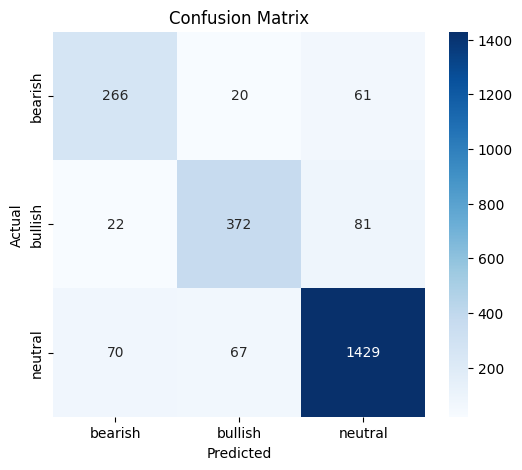

In [49]:
# Confusion matrix
cm = confusion_matrix(valid_labels, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_map.values()), yticklabels=list(label_map.values()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

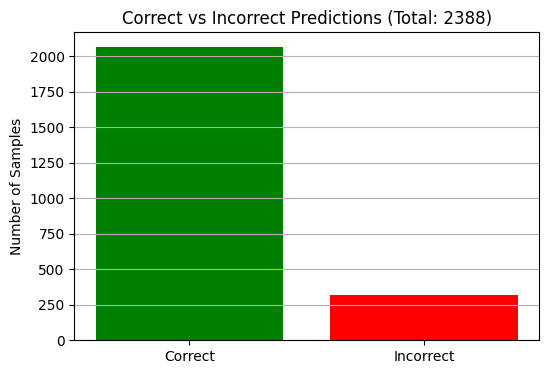

In [50]:


# Compute correct and incorrect predictions
valid_labels_np = np.array(valid_labels)
correct_preds = np.sum(valid_labels_np == predictions)
incorrect_preds = len(valid_labels_np) - correct_preds
total = len(valid_labels_np)

# Plotly Pie chart
fig = px.pie(
    names=['Correct', 'Incorrect'],
    values=[correct_preds, incorrect_preds],
    title=f'Model Performance on Validation Set (Total: {total})',
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_traces(textinfo='label+percent+value')
fig.show()

# (Optional) Bar chart with Matplotlib
plt.figure(figsize=(6, 4))
plt.bar(['Correct', 'Incorrect'], [correct_preds, incorrect_preds], color=['green', 'red'])
plt.title(f'Correct vs Incorrect Predictions (Total: {total})')
plt.ylabel('Number of Samples')
plt.grid(axis='y')
plt.show()


In [51]:
torch.save(model.state_dict(), "finbert_finetuned.pt")


In [52]:
model.config.save_pretrained("finbert_finetuned_config")


In [53]:
torch.save(model, "finbert_finetuned_full.pt")

In [57]:
from transformers import AutoConfig

# Load the configuration
config = AutoConfig.from_pretrained("finbert_finetuned_config")

# Initialize the model with the loaded configuration
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", config=config)

# Load the state dictionary
model.load_state_dict(torch.load("finbert_finetuned.pt"))

<All keys matched successfully>

In [64]:
def predict_sentiment(text):
    # Clean the input text
    cleaned_text = clean_text(text)

    # Tokenize and encode the text
    encoding = tokenizer(cleaned_text, truncation=True, padding=True, return_tensors="pt")
    encoding = {k: v.to(device) for k, v in encoding.items()}

    # Ensure model is on the correct device
    model.to(device)

    # Make a prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**encoding)
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

    # Map the prediction to the sentiment label
    sentiment = label_map[prediction]
    return sentiment

# Get input from the user
user_sentence = input("Enter a sentence to analyze its sentiment: ")

# Get the sentiment prediction
sentiment_prediction = predict_sentiment(user_sentence)

print(f"The sentiment of the sentence is: {sentiment_prediction}")

Enter a sentence to analyze its sentiment: Apple's stock price is expected to fall after the new product launch.
The sentiment of the sentence is: bearish
